In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter


plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

D:\anaconda\envs\HW2\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [3]:
def hourly_return(df):
    return df.close.pct_change()

def maximum_drawdown(df):
    current_high=np.maximum.accumulate(df.high)
    current_low=np.minimum.accumulate(df.low)
    return (current_high-current_low)/current_high

In [4]:
def series_plot(data, title, ax=None):
    data.plot(ax=ax)
    ax.set_title(title)
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [5]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///../../../Lectures/Lecture 4/data/data.db'

In [6]:
# Parameters
from_date = "2021-11-29 00:00:00"
to_date = "2021-12-06 00:00:00"
token = "ETH"
connection_string = "sqlite:///../../../Lectures/Lecture 4/data/data.db"


In [7]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])
prices.sort_values(by=["ts"])
prices.set_index('ts', inplace=True)

In [8]:
prices["hourly_return"]=hourly_return(prices)
prices["hourly_vol"]=vol_ohlc(prices)
prices["maximum_drawdown"]=maximum_drawdown(prices)


In [9]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

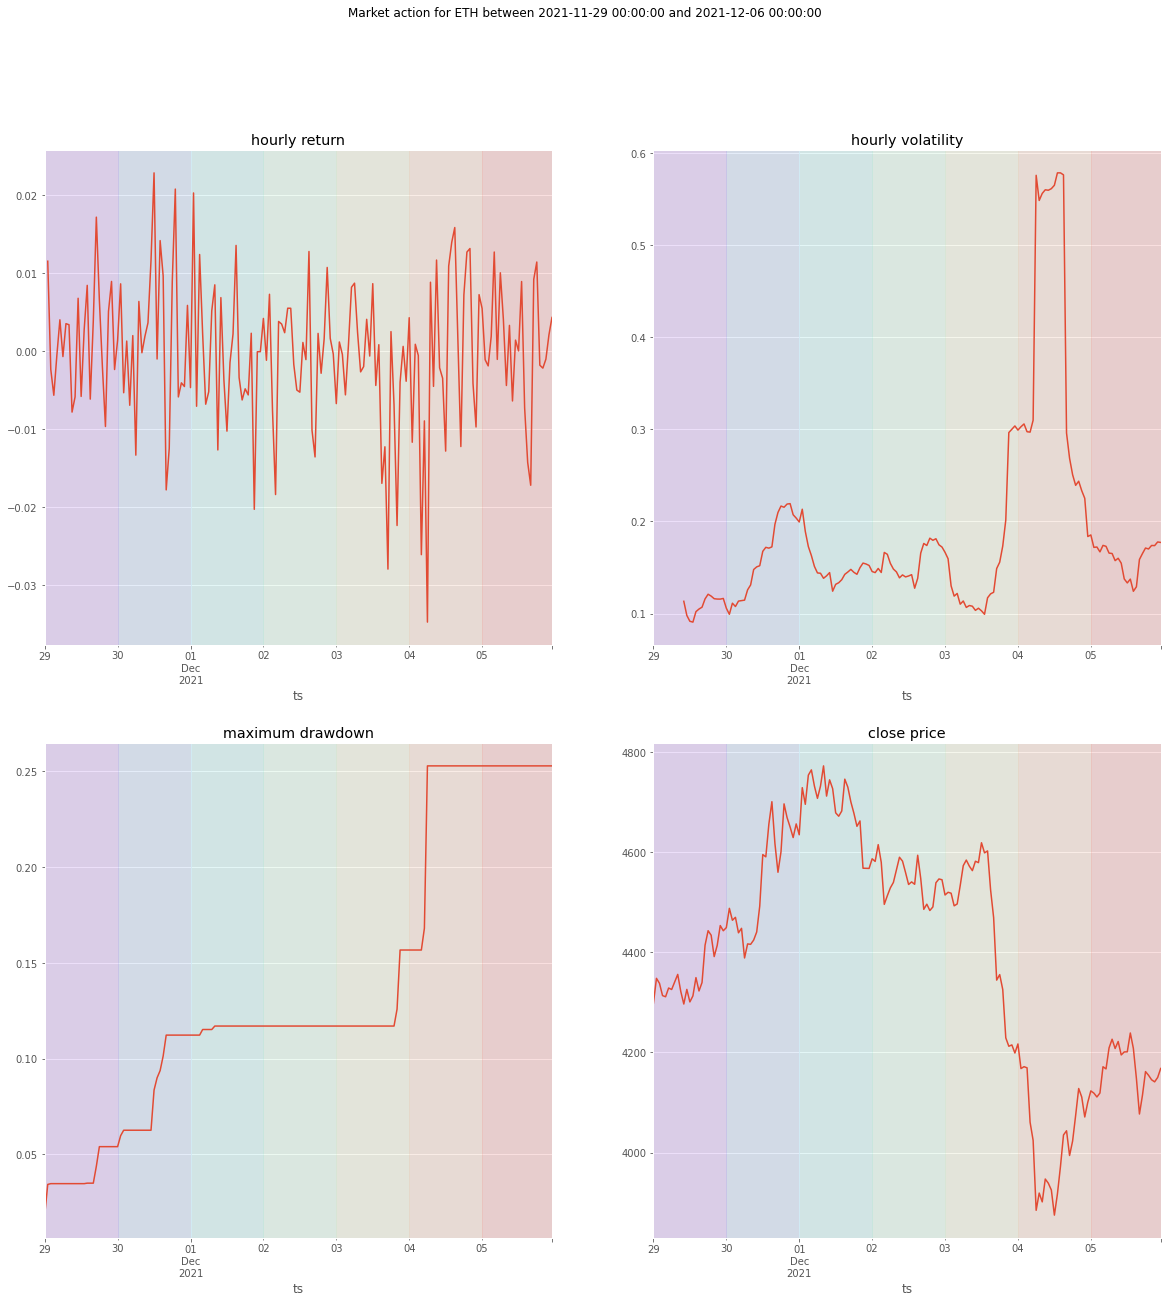

In [10]:
series_plot(prices.hourly_return,"hourly return",ax=ax[0,0])
series_plot(prices.hourly_vol,"hourly volatility",ax=ax[0,1])
series_plot(prices.maximum_drawdown,"maximum drawdown",ax=ax[1,0])
series_plot(prices.close,"close price",ax=ax[1,1])

fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

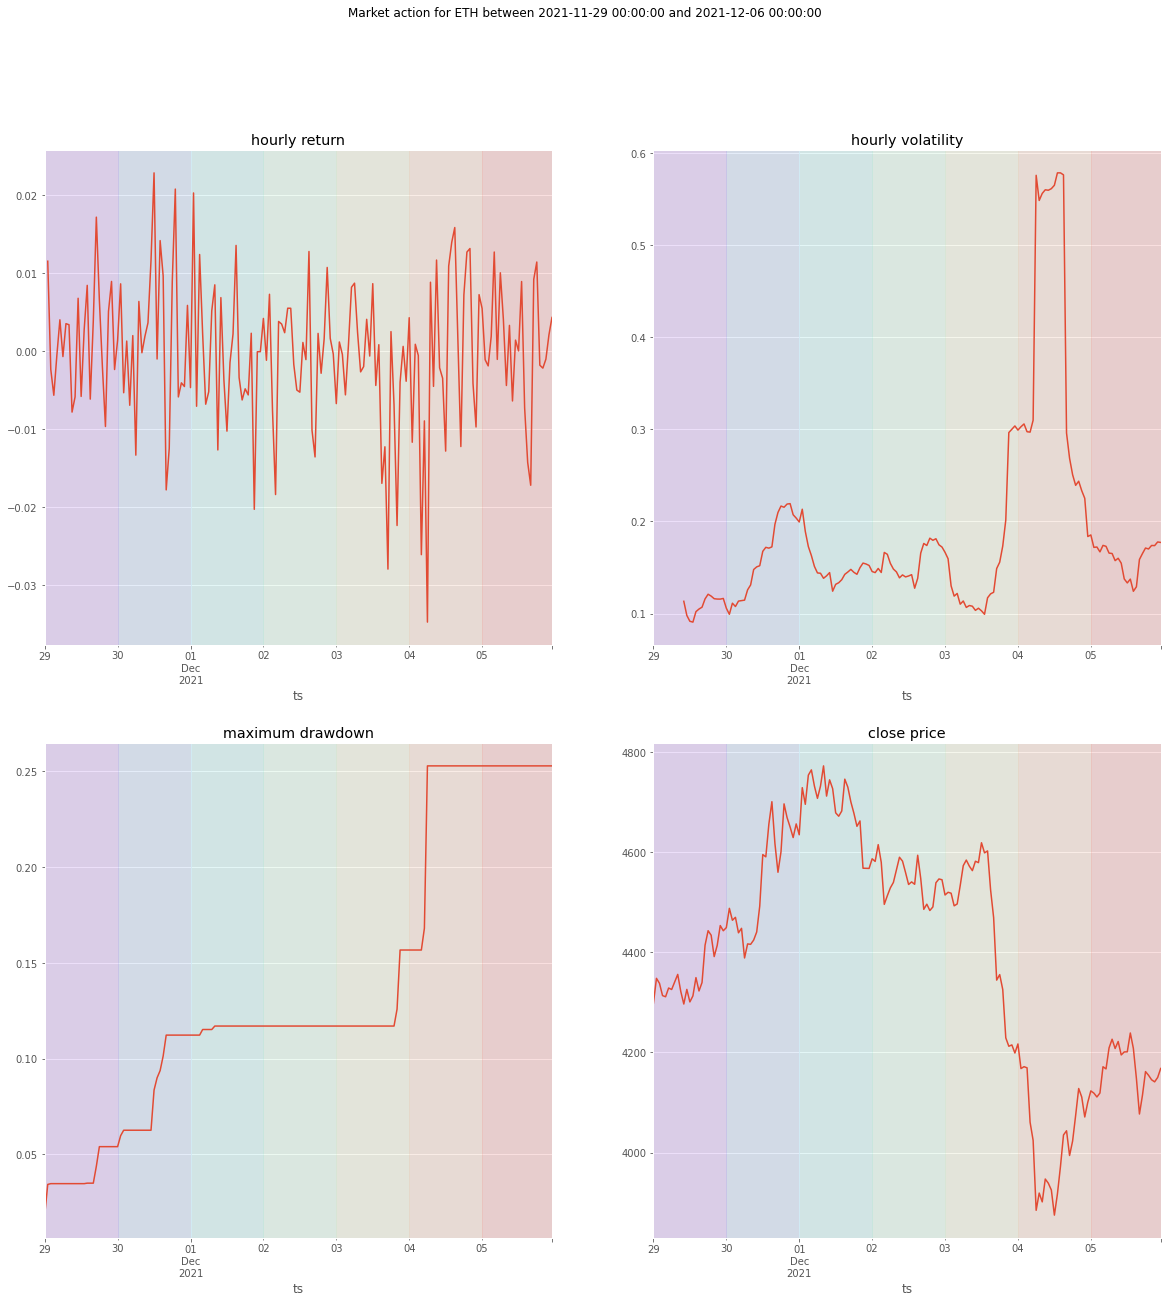

In [11]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)